# Entrenar Detectron 2 con imágenes de botellas

Primero conectamos nuestro notebook a drive para poder obtener todos los datos de una manera mucho más sencilla.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalación de las librerías necesarias.

In [ ]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install LossEvalHook
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 11.7 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=a181677fd15e20766a6e14b6c338b26b50cfc713f9752b9c0e773221bc43ac5b
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/

Importamos las librerías a utilizar.

In [ ]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2

In [ ]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

En esta función se van a armar los diccionarios de datos que nuestro modelo va a ocupar para posteriormente realizar las predicciones de los cuadros delimitadores, así como la segmentación y el nombre de las clases que se utilizan.

In [ ]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 540
        record["width"] = 540
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

Colocamos el path de donde se encuentran nuestros datos de entrenamineto y test.

In [ ]:
data_path = '/content/drive/MyDrive/Detectron2/RefriModeloFinal/refri/'

Registramos nuestro catalogo de clases custom, para poder utilizarlo en el modelo.

In [ ]:
classes = ['Refrigerador']

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

Importamos los componentes del modelo, así como los de visualización.

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

Definimos nuestros archivos de configuración inicial para el modelo, el número de worker, items per batch, así como el número base de resolución, las epocas sobre las que iterara el modelo y el número de clases que estamos manejando.

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ("category_test",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

Aqui unicamente establecemos el directorio donde se encontrará nuestro modelo, así como el tipo de entranamiento que utilizaremos, si este seguira con algun entrenamiento previo o no.

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/04 21:56:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
model_final_f10217.pkl: 178MB [00:10, 16.7MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[12/04 21:57:06 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[12/04 21:57:14 d2.utils.events]:  eta: 0:05:33  iter: 19  total_loss: 1.568  loss_cls: 0.7583  loss_box_reg: 0.08151  loss_mask: 0.6959  loss_rpn_cls: 0.02019  loss_rpn_loc: 0.00807  time: 0.3436  data_time: 0.0600  lr: 4.9953e-06  max_mem: 1863M
[12/04 21:57:20 d2.utils.events]:  eta: 0:05:25  iter: 39  total_loss: 1.451  loss_cls: 0.6515  loss_box_reg: 0.07815  loss_mask: 0.6649  loss_rpn_cls: 0.01837  loss_rpn_loc: 0.007799  time: 0.3376  data_time: 0.0068  lr: 9.9902e-06  max_mem: 1863M
[12/04 21:57:27 d2.utils.events]:  eta: 0:05:18  iter: 59  total_loss: 1.198  loss_cls: 0.4935  loss_box_reg: 0.08036  loss_mask: 0.5989  loss_rpn_cls: 0.01586  loss_rpn_loc: 0.007856  time: 0.3398  data_time: 0.0058  lr: 1.4985e-05  max_mem: 1863M
[12/04 21:57:34 d2.utils.events]:  eta: 0:05:10  iter: 79  total_loss: 0.9964  loss_cls: 0.3433  loss_box_reg: 0.08717  loss_mask: 0.526  loss_rpn_cls: 0.01608  loss_rpn_loc: 0.006336  time: 0.3404  data_time: 0.0073  lr: 1.998e-05  max_mem: 1863M
[12/04

Se definen los pesos que utilizará nuestro modelo, en este caso el del directorio que creamos en el paso anterior.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final_Makima.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.70
cfg.DATASETS.TEST = ("vision_test", )
predictor = DefaultPredictor(cfg)

Definimos el path de la imagen que queremos predecir.

In [ ]:
imagenleer= '/content/drive/MyDrive/Detectron2/imagenesPred/2.jpeg'

Aquí unicamente lo que hacemos es realizar la predicción de la imagen, así como la visualización con matplotlib de la misma.

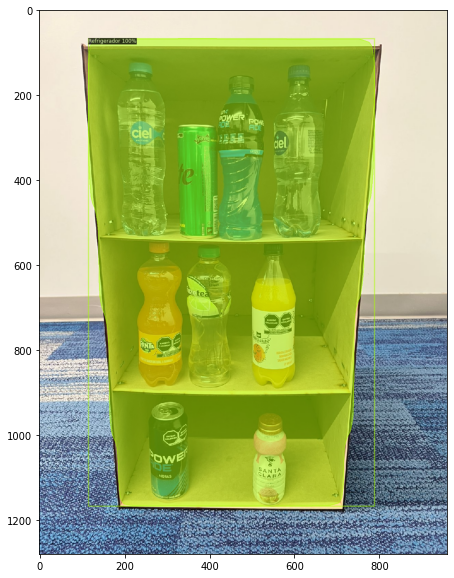

In [ ]:
import matplotlib.pyplot as plt
img = cv2.imread(imagenleer)
plt.figure(figsize=(14,10))
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1],
                metadata=microcontroller_metadata, 
                scale=0.8, 
                #instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

### Recorte de objetos reconocidos

En esta función lo que se realiza es recortar los objetos reconocidos por el modelo, se toma en cuenta los cuadrantes de la bounding box, teniendo esas coordenaadas con PIL e image.crop podemos pasarle los puntos en los que queremos recortar las imagenes.

In [ ]:
import PIL
import operator

def crop_object(image, box, name):
  """Crops an object in an image

  Inputs:
    image: PIL image
    box: one box from Detectron2 pred_boxes
  """
  x_top_left = box[0]
  y_top_left = box[1]
  x_bottom_right = box[2]
  y_bottom_right = box[3]

  crop_img = image.crop((int(x_top_left), int(y_top_left), int(x_bottom_right), int(y_bottom_right)))
  crop_img.save(name)
  plt.figure(figsize=(14,10))
  plt.imshow(crop_img)

Por último, aqui mandamos a llamar a todas las funciones que definimos anteriormente, con las boxes que se obtuvieron de nuestro modelo.

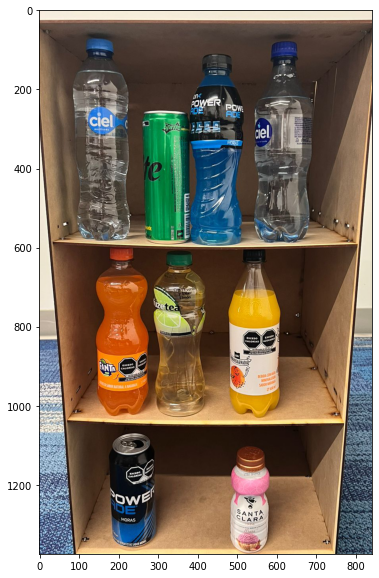

In [ ]:
# Get pred_boxes from Detectron2 prediction outputs
boxes = outputs["instances"].pred_boxes
# Select 1 box:
image = PIL.Image.open(imagenleer).convert('RGB') 
boxes = list(boxes)
listaBoxes = []
for i in range(len(boxes)):
  name = str(i) + "predict.jpg"
  box = boxes[i].detach().cpu().numpy()
  listaBoxes.append(box)
  # Crop the PIL image using predicted box coordinates
  crop_img = crop_object(image, box, name)